# Mammogram data modeling and prediction

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from scipy.io import loadmat
import pandas as pd
from sklearn.model_selection import cross_val_score
import seaborn as sns
import collections

In [2]:
#import the data

filename =  "datasets/cancerWTrain.mat"

mat = loadmat(filename)

Xtrain = mat["cancerTrainX"].T
Ytrain = mat["cancerTrainY"].reshape(len(Xtrain))
Xtest = mat["cancerTestX"].T

#print the size of the arrays 
print("Xtrain", Xtrain.shape)
print("Ytrain", Ytrain.shape)
print("Xtest", Xtest.shape)

Xtrain (400, 30)
Ytrain (400,)
Xtest (169, 30)


Define the PCA objects

In [3]:
from sklearn.decomposition import PCA
pca_plot = PCA(n_components=2, copy=True, whiten=True, svd_solver='randomized', tol=0.0, iterated_power='auto', random_state=None)
pca = PCA(n_components=10, copy=True, whiten=True, svd_solver='randomized', tol=0.0, iterated_power='auto', random_state=None)

Sample plot the training data using only two principal components

<IPython.core.display.Javascript object>


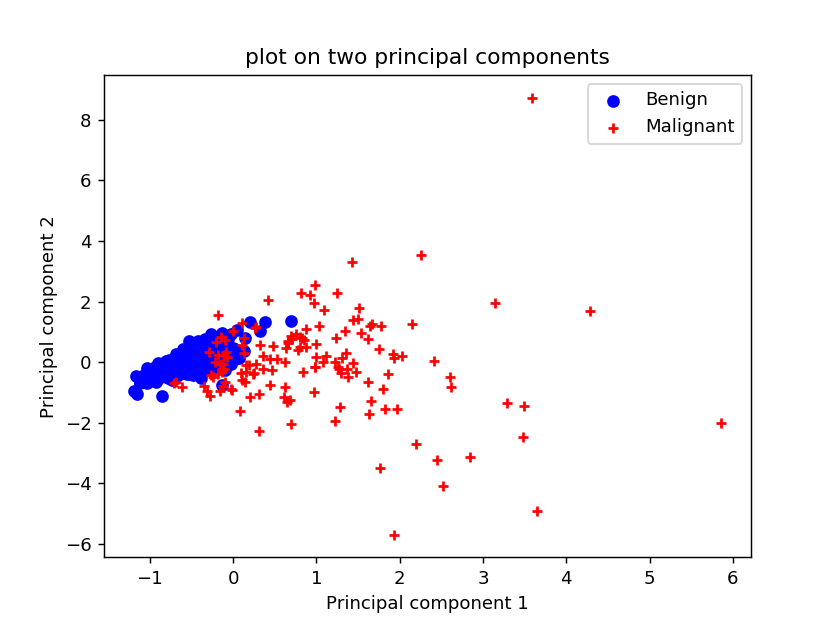

255 Benign and 145 Malignant incidents


In [4]:
Xtrain_plot = pca_plot.fit_transform(Xtrain)
Xtest_plot = pca_plot.transform(Xtest)
X0, X1 = Xtrain_plot[Ytrain == 0], Xtrain_plot[Ytrain == 1 ]

plt.figure()
plt.scatter(X0[:, 0], X0[:, 1], marker='o', color='b', label='Benign')
plt.scatter(X1[:, 0], X1[:, 1], marker='+', color='r', label="Malignant")
plt.title("plot on two principal components")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend()
plt.show()
print("{} Benign and {} Malignant incidents".format(collections.Counter(Ytrain)[0],collections.Counter(Ytrain)[1]))

Find variance in features with PCA after normalizing the data. Normalizing provides improved accuracy

<IPython.core.display.Javascript object>


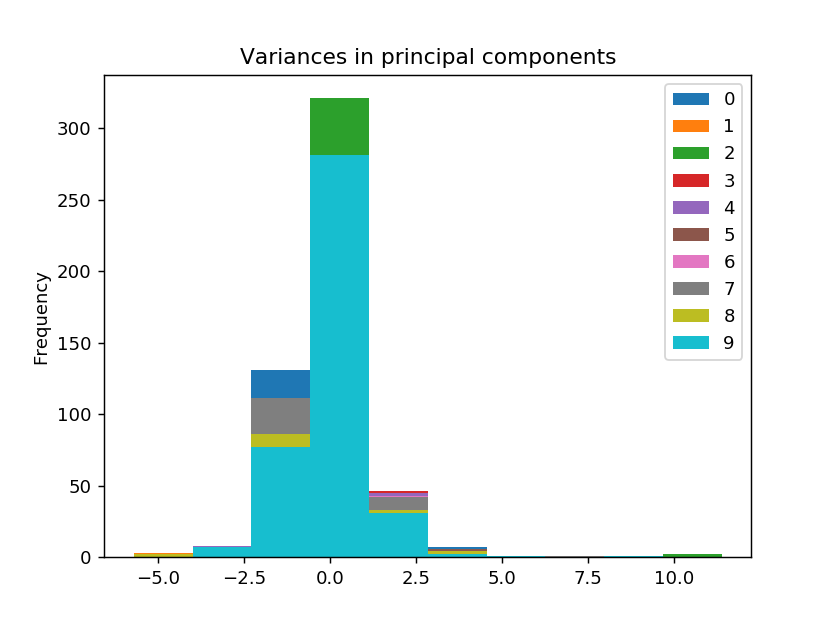

Variance ratios  [9.81765509e-01 1.61860385e-02 1.83060270e-03 1.17757704e-04
 8.78679667e-05 6.43447735e-06 4.25916085e-06 9.00583598e-07
 3.31751101e-07 1.90834083e-07]
Sum of variace ratios  0.9999998925493377


<IPython.core.display.Javascript object>


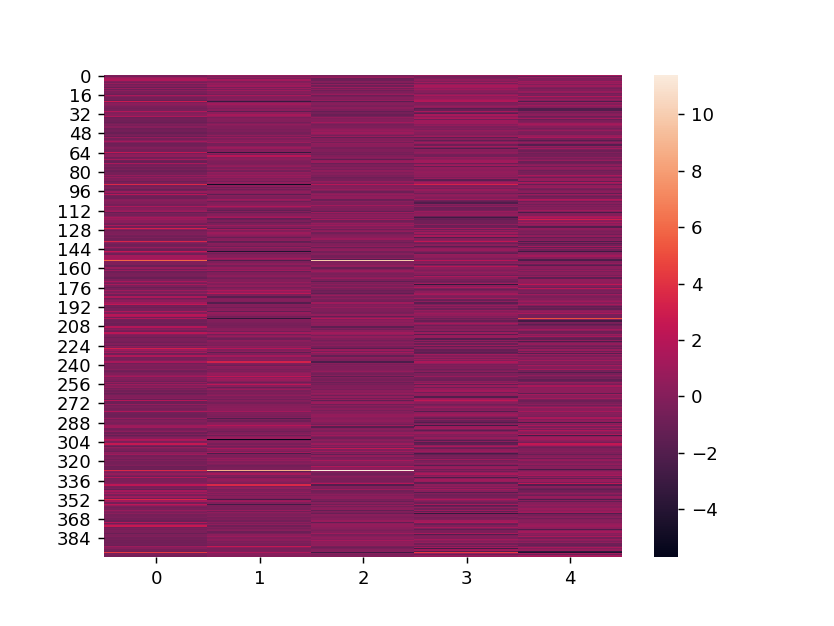

In [5]:
from sklearn.preprocessing import normalize
#Xtrain = normalize(Xtrain, axis=0)
#Xtest = normalize(Xtest, axis=0)
X_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)
#plot both the training data reduced by pca to see the variance in the datset 
pd.DataFrame(X_pca).plot(kind='hist', title='Variances in principal components')
plt.show()
print("Variance ratios ", pca.explained_variance_ratio_)
print("Sum of variace ratios ", np.sum(pca.explained_variance_ratio_))
plt.figure()
ax = sns.heatmap(X_pca[:,:5])

In [6]:
#set cross validation metrics
kf = 10

Try MLP classifier

<IPython.core.display.Javascript object>


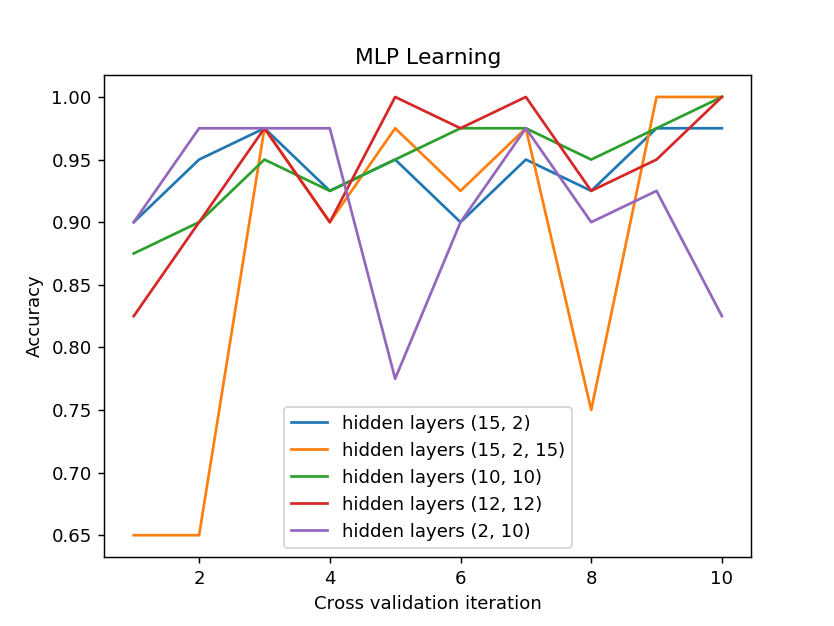

Mean accuracy [0.9424999999999999, 0.8800000000000001, 0.9475, 0.945, 0.9125]
Maximum accuracy 0.9475
Number of hidden layers (10, 10)


In [17]:
from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale
mean_accuracy = []
hl_numbers  = [(15, 2), (15, 2, 15) , (10, 10), (12, 12), (2,10)]
X_scale = scale(X_pca)
plt.figure()
for hl in hl_numbers:
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=hl, random_state=0, max_iter=1000)
    scores_mlp = cross_val_score(mlp, X_scale, Ytrain, cv=kf)
    mean_accuracy.append(scores_mlp.mean())
    plt.plot(range(1, len(scores_mlp)+1),scores_mlp , label="hidden layers {}".format(hl))
plt.ylabel("Accuracy")
plt.xlabel("Cross validation iteration")
plt.title("MLP Learning")
plt.legend()
plt.show()
print("Mean accuracy", mean_accuracy)
max_accuracy = max(mean_accuracy)
print("Maximum accuracy", max_accuracy)
print("Number of hidden layers", hl_numbers[mean_accuracy.index(max_accuracy)])

Try support vector classifier and find the accuracy

<IPython.core.display.Javascript object>


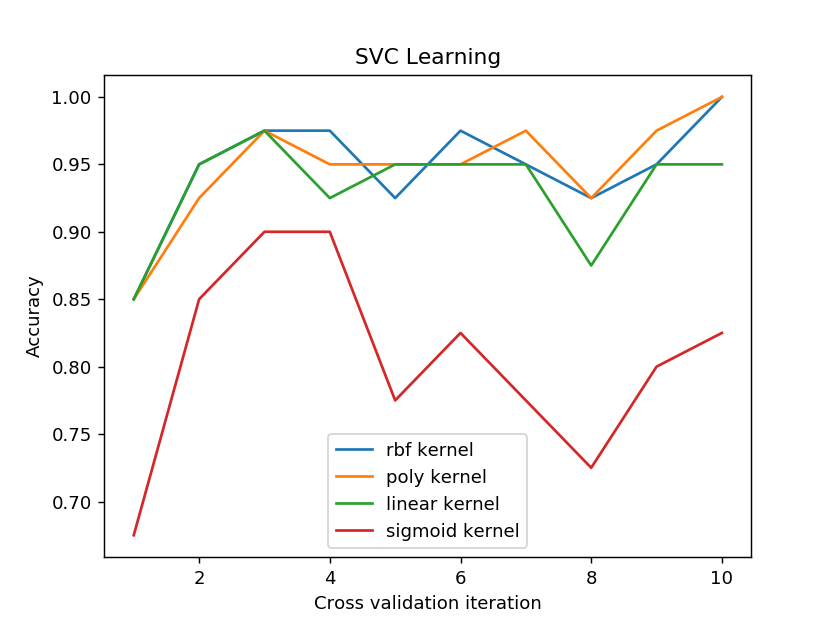

Maximum accuracy 0.9475
Best method ' rbf ' kernel


In [8]:
from sklearn.svm import SVC
#try SVM classifier
kernel_arr = ['rbf', 'poly', 'linear', 'sigmoid']
mean_accuracy = []
plt.figure()
for kernel in kernel_arr:
    svc = SVC(kernel=kernel, C=1, gamma='scale', degree=2, coef0=1)
    scores_svc = cross_val_score(svc, X_pca, Ytrain, cv=kf)
    mean_accuracy.append(scores_svc.mean())
    plt.plot(range(1, len(scores_svc)+1),scores_svc, label='%s kernel'%kernel)
plt.ylabel("Accuracy")
plt.xlabel("Cross validation iteration")
plt.title("SVC Learning")
plt.legend()
plt.show()
max_accuracy = max(mean_accuracy)
print("Maximum accuracy", max_accuracy)
print("Best method '", kernel_arr[mean_accuracy.index(max_accuracy)],"' kernel" )

These gives similar accuracy, so we will go for SVC and predict on the test data given to us

<IPython.core.display.Javascript object>


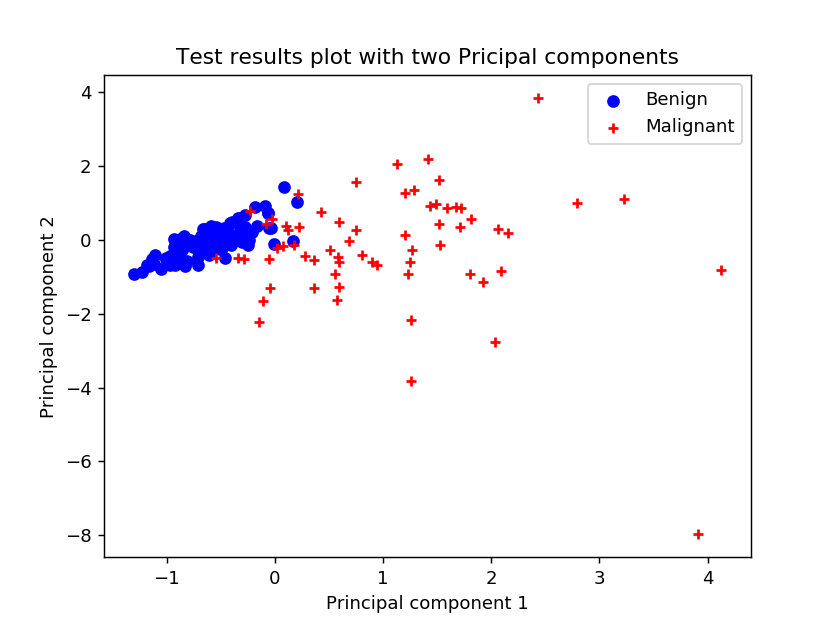

104 Benign and 65 Malignant incidents


In [18]:
svc = SVC(kernel='rbf', C=1, gamma='scale')
svc.fit(X_pca, Ytrain)

Ytest = svc.predict(Xtest_pca)
XT0, XT1 = Xtest_plot[Ytest == 0], Xtest_plot[Ytest == 1]
plt.figure()
plt.scatter(XT0[:, 0], XT0[:, 1], marker="o", color='b', label="Benign")
plt.scatter(XT1[:, 0], XT1[:, 1], marker="+", color='r', label="Malignant")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.title("Test results plot with two Pricipal components")
plt.legend()
plt.show()
print("{} Benign and {} Malignant incidents".format(collections.Counter(Ytest)[0],collections.Counter(Ytest)[1]))